## Create Quality Helicorder

### Imports

In [16]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt 
import obspy 

from andbro__save_to import __save_to
from pandas import read_csv, DataFrame
from matplotlib.patches import Polygon, Patch


from tqdm import tqdm


In [17]:

def __archive_request(seed_id, tstart, tdelta, raw=None):
    
    ''' get data of ROMY for one component from archive 

    VARIABLES:
        seed_id:    code of seismic stations (e.g. "BW.ROMY..BJU")
        tstart:	    begin of time period
        tdelta:     temporal length of period

    DEPENDENCIES:
        import obspy

    EXAMPLE:
        >>> __get_stream_data_archive('BW.ROMY.10.BJZ', '2020-07-17 02:50', 3600, raw=False)

    '''
    from obspy.clients.fdsn import Client

#     print(" requesting data from archive...")

    net, sta, loc, cha = seed_id.split(".")
    
    ## defining parameters
    year = tstart.year
    doy  = tstart.julday
    tend = tstart + tdelta
    
    ## define station depending if raw is set or not
#     sta = sta if raw is None else f"D{sta}"

    ## define local data path
    pathroot = "/import/freenas-ffb-01-data/romy_archive/"

    ## __________________________________________________________________________
    
    try:
        route = obspy.clients.fdsn.RoutingClient("eida-routing")
        inv   = client.get_stations(network=net, station=sta, level="response")
#         print("  --> inventory was obtained"); obtained_inventory=True

    except:
        if raw is not True:
            print("  --> inventory could not be obtained..."); obtained_inventory=False
    
    ## -------------------------- ##
    if raw is None or raw is False:
        ## recreate file structure of archive
        path = f"{pathroot}{year}/{net}/{sta}/{cha}.D/"
        name = f"{net}.{sta}.{loc}.{cha}.D.{year}.{doy}"
        ## get stream data
        st = obspy.read(path+name, starttime=tstart, endtime= tend)
        
        if obtained_inventory:
            print("  --> trend and response is being removed...")
            return st.detrend("linear").remove_response(inventory=inv) 
        else:
            return st   

    ## -------------------------- ##
    elif raw is True: 
        if sta == "ROMY":
            ## recreate file structure of archive
            path = f"{pathroot}{year}/{net}/DROMY/FJ{cha[2]}.D/"
            name = f"{net}.D{sta}..F{cha[1:3]}.D.{year}.{doy}"
            ## get stream data
            st = obspy.read(path+name, starttime=tstart, endtime= tend)
            return st
        else:
            print("  --> something went wrong! perhaps with seed_id?")


In [18]:
##
# def __evaluate_quality(trace, opath):
    
# #     print(" evaluating data...")
    
#     samples = trace[0].stats.npts
#     deltaT  = trace[0].stats.delta
#     steps = int(60 / deltaT) # every minute


#     intervalls = np.arange(0,samples,steps)

#     minute_axis = np.arange(steps/2,samples-steps/2,steps) 
#     minute_axis_time = []
#     for l in minute_axis:
#         minute_axis_time.append(trace[0].times()[int(l)])

#     ## allocate memory for variables

#     delta_min    = np.zeros(len(intervalls[:-1]))
#     delta_max    = np.zeros(len(intervalls[:-1]))
#     sigma_minute = np.zeros(len(intervalls[:-1]))
#     mean_minute  = np.zeros(len(intervalls[:-1]))
#     ifreq        = np.zeros(len(intervalls[:-1]))

    
#     for k, idx in enumerate(range(0,len(intervalls[:-1]))):
#             x = trace[0][intervalls[idx]:intervalls[idx+1]]
# #             print(intervalls[idx]*deltaT/60,"min", "-", intervalls[idx+1]*deltaT/60, "min")

#             Nseconds = 2 # every 2 seconds
#             binsize = Nseconds / deltaT 
#             overlap = int(binsize/4)


#             bins=np.arange(binsize/2, len(x)-binsize/2+overlap, overlap)

#             ## allocate variable memory
#             dif_tmp   = np.zeros(len(bins))
#             avg_tmp   = np.zeros(len(bins))
#             std_tmp   = np.zeros(len(bins))
#             ifreq_tmp = np.zeros(len(bins))

#             for l, xbin in enumerate(bins):

#                 wdata=x[int(xbin-binsize/2):int(xbin+binsize/2)]

#                 avg_tmp[l] = (np.mean(wdata))

#                 std_tmp[l] = (np.std(wdata))

#                 dif_tmp[l] = (np.abs(np.max(wdata))-np.abs(np.min(wdata)))

#                 ifreq_tmp[l] = (np.nonzero(np.diff(wdata-np.mean(wdata) > 0))[0].size) /2 /Nseconds
        

#             ## assign values to vectors
#             mean_minute[k] = (np.mean(avg_tmp))
#             sigma_minute[k] = (np.std(std_tmp))
#             delta_max[k] = (np.max(dif_tmp))
#             delta_min[k] = (np.min(dif_tmp))
#             ifreq[k] = np.mean(ifreq_tmp)
            
#             del avg_tmp, std_tmp, dif_tmp, ifreq_tmp
    
#     ## calulcate offset to add for each iteration (time and samples) 
#     toffset = trace[0].stats.starttime.time.hour*3600+trace[0].stats.starttime.time.minute*60+trace[0].stats.starttime.time.second
#     soffset = toffset/trace[0].stats.delta
    
#     ## create output filename
#     oname = f"{trace[0].stats.starttime.date}.Q"
    
#     ## writing output
#     out = open(opath + oname, "a+")
    
#     for idx in range(0,len(minute_axis)):
#         out.write(f"{soffset+minute_axis[idx]} {toffset+minute_axis_time[idx]} {mean_minute[idx]} {sigma_minute[idx]} {delta_max[idx]} {delta_min[idx]} {ifreq[idx]}\n")
#     out.close()


In [19]:

def __plotQualityHelicorder(trace, colors, intervall, hours_to_show=12, hours_shift=None):

    
#     intervall = 15 # minutes
#     hours_to_show = 12 # hours
#     hours_shift = 12 # hours    

    factor = 2 # offset of lines

    tstart = trace[0].stats.starttime
    

    ## modify time the helicorder start 
    if hours_shift:
        tstart += hours_shift*3600

    ## ___________________________________________________________
    ##

    fig, ax  = plt.subplots(1,1, figsize=(15,15))

    fs = 14

    for k in range(int(hours_to_show*60/intervall)):
        
        ## define time windows according to set intervall variable
        dt_min = k*intervall*60
        dt_max = (k+1)*intervall*60

        if hours_shift:
            t1 = hours_shift*3600 + dt_min
            t2 = hours_shift*3600 + dt_max
        else:
            t1 = dt_min
            t2 = dt_max
    
        #load data for current window
        dat1 = trace.slice(tstart+dt_min,tstart+dt_max).detrend('simple')
        dat2 = colors[(colors.seconds <= t2) & (colors.seconds >= t1)].reset_index()

        ## automatically generate time axis
        timeline = np.arange(0,intervall*60, intervall*60/len(dat1[0].data))
        
        ## plot trace data
        ax.plot(timeline, dat1[0].data/max(dat1[0].data)-factor*k, 'k')

        ## add color polygons according to quality
        for i in range(len(dat2.seconds)-1): 

            x1, x2, y1, y2 = dat2.iloc[i,1]-t1, dat2.iloc[i+1,1]-t1, -factor*k-1.0, -factor*k+1.0

            if dat2.quality[i] == 0:
                q0 = ax.add_patch(Polygon([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], closed=True, fill=True, color='green',alpha=0.5, lw=0.0))
                
            if dat2.quality[i] == 1:
                q1 = ax.add_patch(Polygon([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], closed=True, fill=True, color='yellow',alpha=0.5, lw=0.0))

            if dat2.quality[i] == 2:
                q2 = ax.add_patch(Polygon([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], closed=True, fill=True, color='darkorange',alpha=0.5, lw=0.0))

            if dat2.quality[i] == 3:
                q3 = ax.add_patch(Polygon([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], closed=True, fill=True, color='darkred',alpha=0.5, lw=0.0))

    ## axes configurations
    ax.set_xlabel('Time (min)',fontsize = fs)
    ax.set_xticks(np.arange(0,900+60*1,60*1))
    ax.set_xticklabels([0,'','','','',5,'','','','',10,'','','','',15], fontsize=fs-1)
    
    ax.set_ylabel(f'UTC from {tstart.date}', fontsize=fs)
    ax.set_yticks(np.arange(0,-hours_to_show*8,-factor*4))
    
    ## define y-labels
    hourlabels = []
    for i in range(hours_to_show):
        if hours_shift:
            i += hours_shift
        if i < 10:
            hourlabels.append(f'0{i}:00')
        else:
            hourlabels.append(f'{i}:00')
    
    ax.set_yticklabels(hourlabels, fontsize=fs-1)
   
    ## add a title
    ax.set_title(f'{dat1[0].stats.network}.{dat1[0].stats.station}.{dat1[0].stats.location}.{dat1[0].stats.channel}', fontsize=fs+2)

    ## add legend 
    legend_elements = [Patch(facecolor='green', edgecolor='green', label='Q0'),
                       Patch(facecolor='yellow', edgecolor='yellow', label='Q1'),
                       Patch(facecolor='darkorange', edgecolor='darkorange', label='Q2'),
                       Patch(facecolor='darkred', edgecolor='darkred', label='Q3')
                      ]

    ax.legend(handles=legend_elements, loc='upper center', fontsize=fs, ncol=4, edgecolor='black')



#     plt.show();
    return fig


### Variables

In [38]:
path = '/home/brotzer/Documents/ROMY/ROMY_QualityCheck/'


## interactively 
if len(sys.argv) > 1:
    date_to_analyse = sys.argv[1]
    channel = sys.argv[2]
else:
    date_to_analyse = input("\n Enter the date (e.g. 2019-05-14):  "); print("\n")
    channel = input("\n Enter the date (e.g. 2019-05-14):  "); print("\n")

## manually
# date_to_analyse = '2019-11-01'
# channel = 'BJZ'


date_to_analyse = obspy.UTCDateTime(date_to_analyse)


## setting input paths and files automatically
ipath = f'{path}Cfiles/{str(date_to_analyse)[:7]}/'
iname = f'{date_to_analyse.date}.C{channel[-1]}'

# opath = f'{path}Cfiles/'
# ofile = f'{date_to_analyse.date}.C'

opathfigs = f'{path}QHeli/{str(date_to_analyse)[:7]}/'
onamefigs = f'ROMY_{date_to_analyse.date}_Q{channel[-1]}heli'

## seed code
code = f"BW.ROMY.10.{channel}"

## important for helicorder devision
time_intervall = 15 # minutes



In [40]:
if not os.path.isfile(ipath+iname):
    print(f"\nNo input file found: {ipath+iname}")
    sys.exit()

### Load waveform data

In [30]:

tstart = obspy.UTCDateTime(date_to_analyse)

tdelta = 1440 # minutes

tr = __archive_request(code, tstart, tdelta*60, raw=False)

#bjz.plot(type="dayplot", intervall=15);

  --> inventory could not be obtained...


### Load quality data

In [31]:
## infer input filename
# iname = f"{tstart.date}.C"

## read the quality data for the component
colors_in = read_csv(ipath+iname, names=['idx', 'seconds', 'quality'], header=0)

## define array with intervall cuts as seconds
edges = np.arange(0,1440*60+60*time_intervall,60*time_intervall)

## creating a data frame with values at the cuts of the intervall for the helicorder
df = DataFrame({"idx":np.zeros(len(edges))*np.NaN, "seconds":edges, "quality":np.zeros(len(edges))*np.NaN})

## joining the dataframes and sort of extrapolating the quality values
colors = colors_in.append(df).sort_values('seconds').reset_index().fillna(method='ffill')
colors = colors[['seconds', 'quality']]
colors.quality.iloc._setitem_with_indexer(0, colors.quality.iloc[1])


colors.head()


,seconds,quality
0,0.0,3.0
1,30.0,3.0
2,900.0,3.0
3,1800.0,3.0
4,2700.0,3.0



 --> saving pdf to /home/brotzer/Documents/ROMY/ROMY_QualityCheck/QHeli/2019-11/ROMY_2019-11-02_QHeli(1).pdf... 


* Done


 --> saving pdf to /home/brotzer/Documents/ROMY/ROMY_QualityCheck/QHeli/2019-11/ROMY_2019-11-02_QHeli(2).pdf... 


* Done



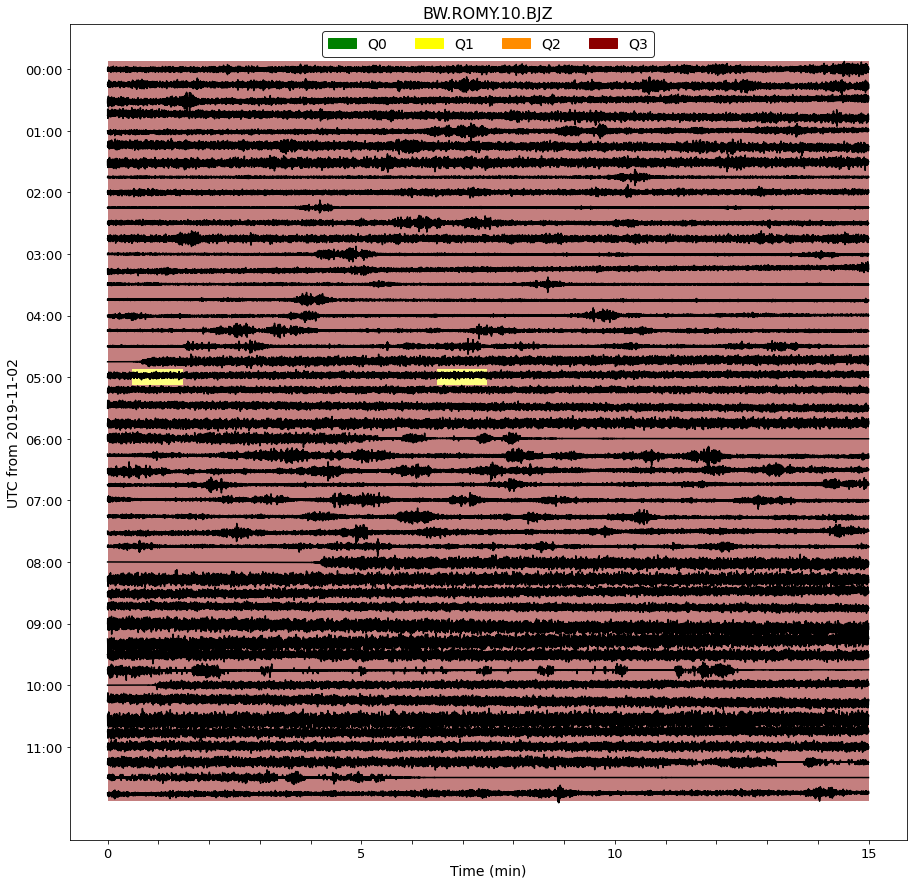

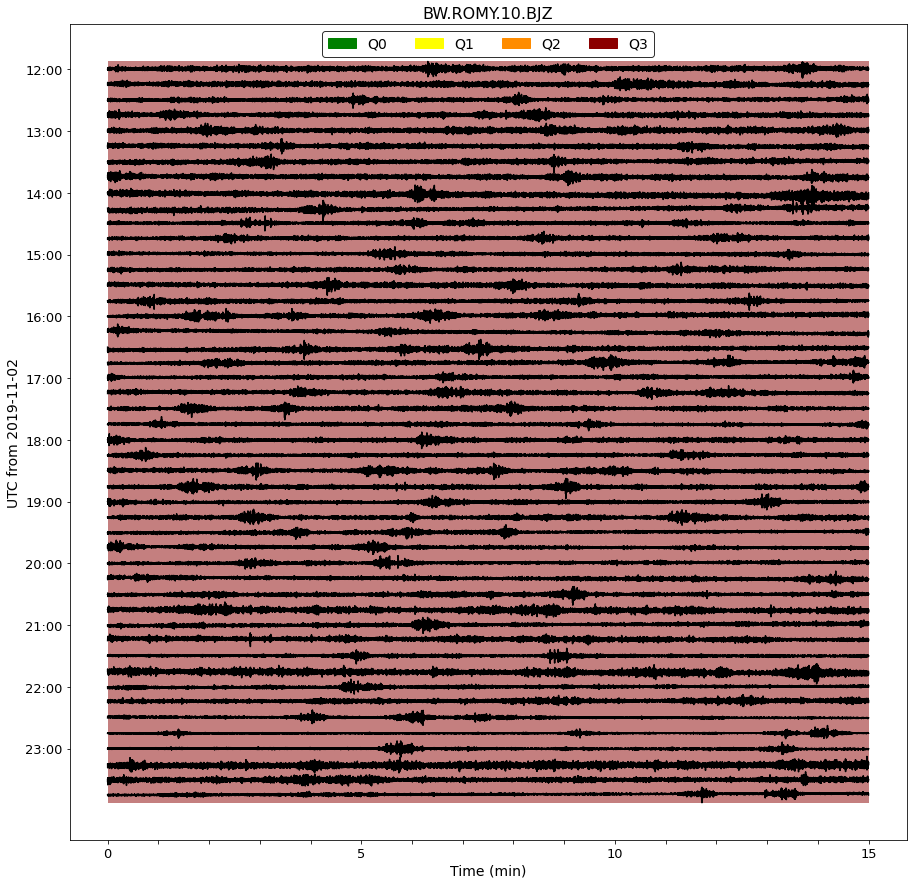

In [32]:
if not os.path.isdir(opathfigs):
    os.mkdir(opathfigs)

## auto define output filename
oname = f'ROMY_{tstart.date}_QHeli(1)'

## generate plot
fig = __plotQualityHelicorder(tr, colors, intervall=time_intervall, hours_to_show=12, hours_shift=None)

## save plot as pdf 
__save_to(fig, outpath=opathfigs, outname=oname, mode="pdf");

## _____________________________________________
##

## auto define output filename
oname = f'ROMY_{tstart.date}_QHeli(2)'

## generate plot
fig = __plotQualityHelicorder(tr, colors, intervall=time_intervall, hours_to_show=12, hours_shift=12)

## save plot as pdf 
__save_to(fig, outpath=opathfigs, outname=oname, mode="pdf");
